Importing necessary libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import joblib

Loading the dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 45.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.82MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.85MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Subset creation for classes 3 and 8

In [3]:
train_mask = torch.tensor([(target == 8 or target == 3) for target in trainset.targets])
test_mask = torch.tensor([(target == 8 or target == 3) for target in testset.targets])

trainset.data = trainset.data[train_mask]
trainset.targets = torch.tensor(trainset.targets)[train_mask]
testset.data = testset.data[test_mask]
testset.targets = torch.tensor(testset.targets)[test_mask]

<ipython-input-3-7678150fcea2>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset.targets = torch.tensor(trainset.targets)[train_mask]
<ipython-input-3-7678150fcea2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset.targets = torch.tensor(testset.targets)[test_mask]


Converting to binary (1-Digit 3, 0-Digit 8)

In [4]:
trainset.targets = torch.tensor([1 if target == 3 else 0 for target in trainset.targets])
testset.targets = torch.tensor([1 if target == 3 else 0 for target in testset.targets])

In [5]:
generator = torch.Generator().manual_seed(42)

Splitting into train and validation

In [6]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size],generator=generator)
print(len(train_dataset), len(val_dataset), len(testset))

9585 2397 1984


Class distribution

Label
1    6131
0    5851
Name: count, dtype: int64


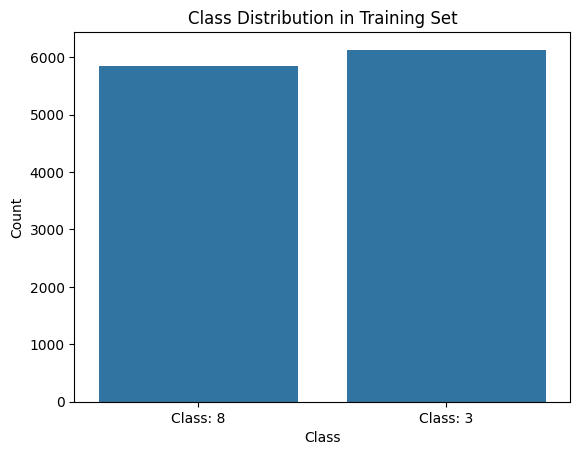

In [7]:
y_train = trainset.targets

df = pd.DataFrame({'Label': y_train})
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class: 8', 'Class: 3'])
plt.show()

In [8]:
print(f"Image shape: {trainset.data[0].shape}")
print(f"Image data type: {trainset.data.dtype}")

Image shape: torch.Size([28, 28])
Image data type: torch.uint8


Displaying sample images

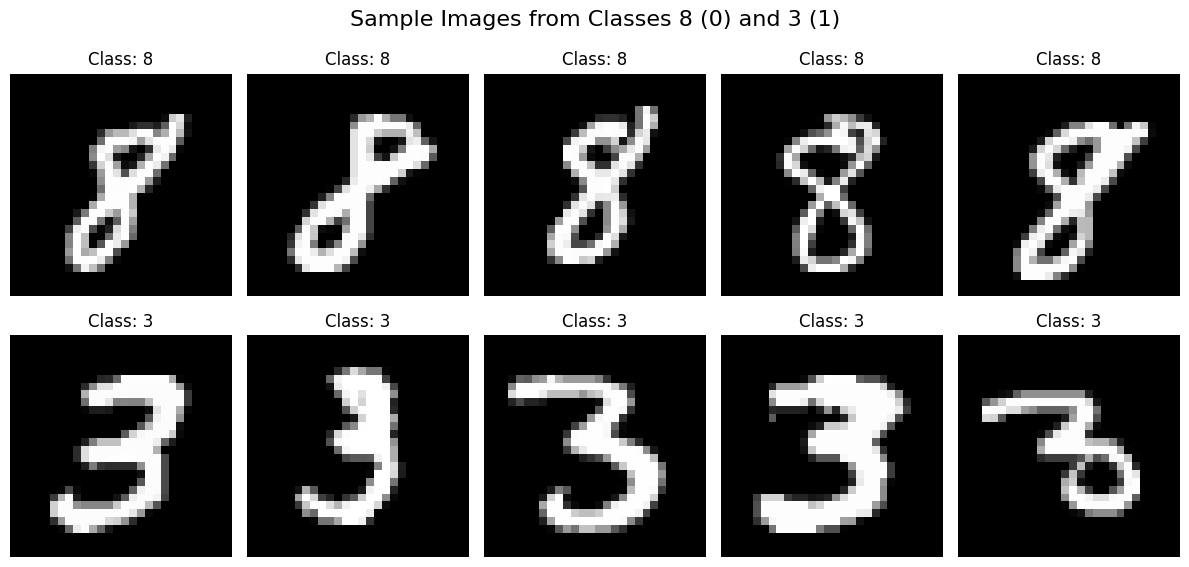

In [9]:
x_train = trainset.data.numpy()
y_train = trainset.targets.numpy()


fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample Images from Classes 8 (0) and 3 (1)', fontsize=16)
for i in range(5):
    axes[0, i].imshow(x_train[y_train == 0][i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title("Class: 8")
    axes[0, i].axis('off')
    axes[1, i].imshow(x_train[y_train == 1][i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title("Class: 3")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

Initial Modeling of SVC

In [10]:
def prepare_data(dataset):
    data = []
    labels = []
    for images, targets in DataLoader(dataset, batch_size=len(dataset)):
        data.append(images.numpy().reshape(len(images), -1))
        labels.append(targets.numpy())
    return np.vstack(data), np.hstack(labels)

X_train, y_train = prepare_data(train_dataset)
X_val, y_val = prepare_data(val_dataset)
X_test, y_test = prepare_data(testset)

Scaling the data

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Initialising SVC model with rbf kernel

In [12]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)


In [13]:
print("Training SVM with default parameters")
svm_model.fit(X_train_scaled, y_train)

Training SVM with default parameters


SVC(probability=True, random_state=42)

Evaluation on validation set

In [14]:
val_pred = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy with default parameters: {val_accuracy:.4f}")

Validation Accuracy with default parameters: 0.9804


Confusion matrix

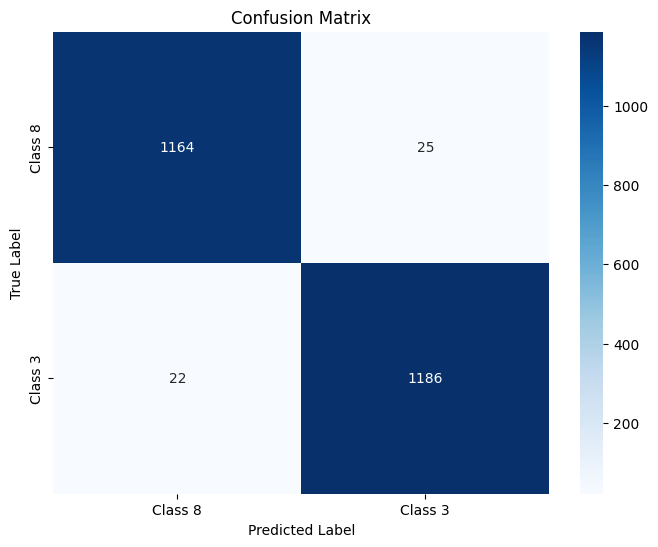

In [16]:
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 8', 'Class 3'],
            yticklabels=['Class 8', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Hyperparameter Tuning Using GridSearch

In [17]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

print("Performing grid search")
grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid.fit(X_train_scaled, y_train)

print("\nBest parameters found:")
print(grid.best_params_)
print(f"\nBest cross-validation accuracy: {grid.best_score_:.4f}")

final_model = grid.best_estimator_

y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]


Performing grid search
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters found:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Best cross-validation accuracy: 0.9853


Training final model with best parameters

In [18]:
best_params = grid.best_params_
print("Training SVM with best parameters")
best_svm_model = SVC(**best_params, probability=True, random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

Training SVM with best parameters


SVC(C=100, gamma=0.001, probability=True, random_state=42)

Evaluation on validation set

In [19]:
val_pred = best_svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy with best parameters: {val_accuracy:.4f}")

Validation Accuracy with best parameters: 0.9896


Evaluation on test Set

In [26]:
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9854


ROC Curve

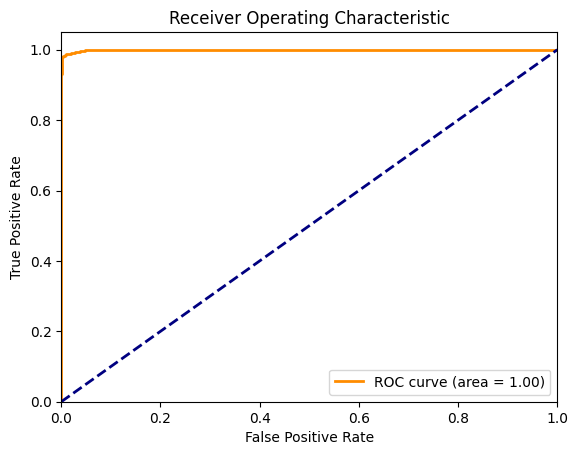

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Per Class Accuracy

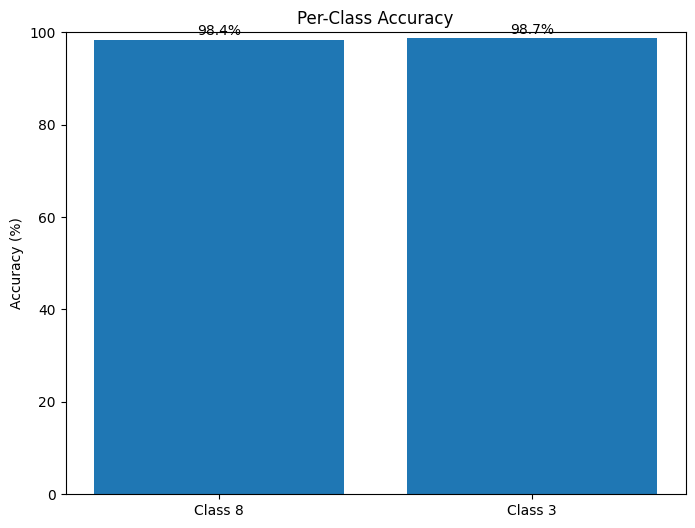


Per-class Accuracy:
Class 8: 98.36%
Class 3: 98.71%


In [25]:
def plot_per_class_accuracy(y_true, y_pred):
    class_names = ['Class 8', 'Class 3']
    accuracies = []
    for i in range(2):
        mask = (np.array(y_true) == i)
        class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
        accuracies.append(class_acc)
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, accuracies)
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.ylim([0, 100])
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')
    plt.show()
    print("\nPer-class Accuracy:")
    for name, acc in zip(class_names, accuracies):
        print(f"{name}: {acc:.2f}%")

plot_per_class_accuracy(y_test, y_pred)

C vs train and test accuracy

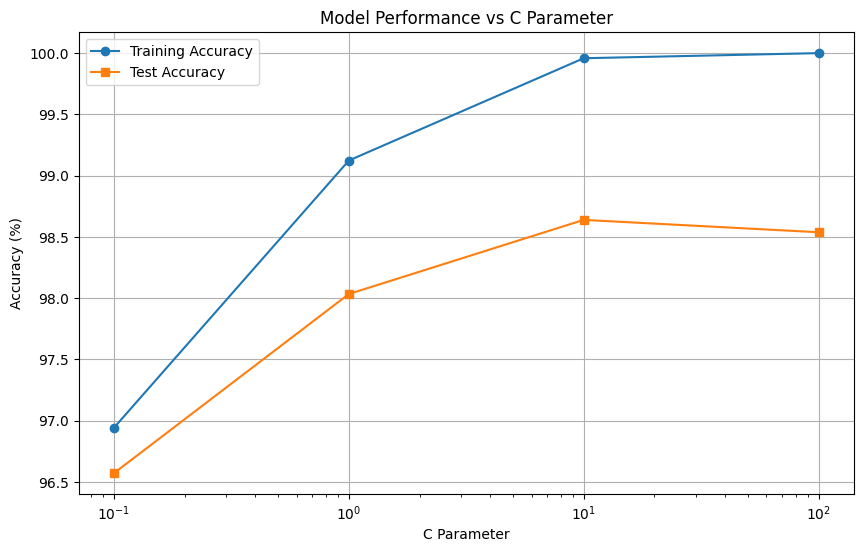

In [27]:
C_values = param_grid['C']
train_scores = []
test_scores = []

for C in C_values:
    model = SVC(C=C, gamma=best_params['gamma'], kernel='rbf', probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)

    train_acc = model.score(X_train_scaled, y_train) * 100
    test_acc = model.score(X_test_scaled, y_test) * 100

    train_scores.append(train_acc)
    test_scores.append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, marker='o', label='Training Accuracy')
plt.plot(C_values, test_scores, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C Parameter')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs C Parameter')
plt.legend()
plt.grid(True)
plt.show()

Number of samples vs train and test accuracy

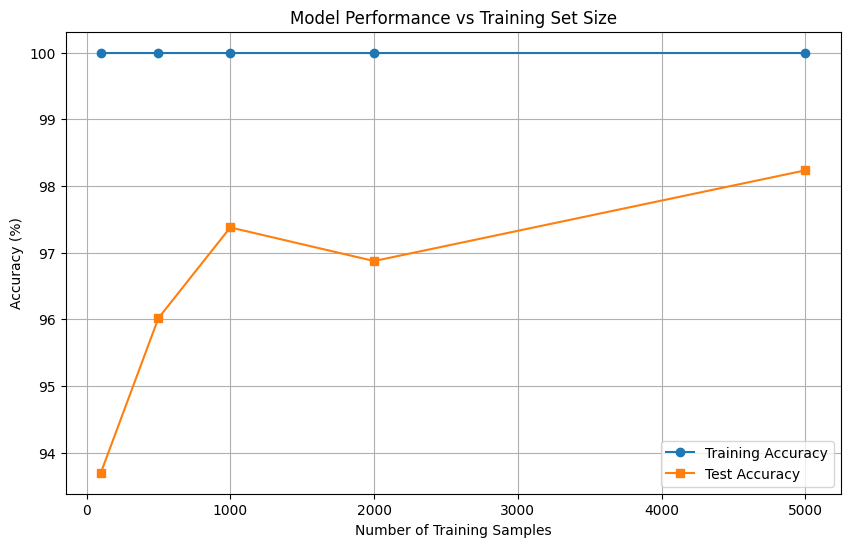

In [28]:
sample_sizes = [100, 500, 1000, 2000, 5000]
sample_results = {'train_acc': [], 'test_acc': []}

for n_samples in sample_sizes:
    indices = np.random.choice(len(X_train_scaled), n_samples, replace=False)
    X_train_subset = X_train_scaled[indices]
    y_train_subset = y_train[indices]

    model = SVC(**best_params, probability=True, random_state=42)
    model.fit(X_train_subset, y_train_subset)

    train_acc = model.score(X_train_subset, y_train_subset) * 100
    test_acc = model.score(X_test_scaled, y_test) * 100

    sample_results['train_acc'].append(train_acc)
    sample_results['test_acc'].append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, sample_results['train_acc'], marker='o', label='Training Accuracy')
plt.plot(sample_sizes, sample_results['test_acc'], marker='s', label='Test Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix

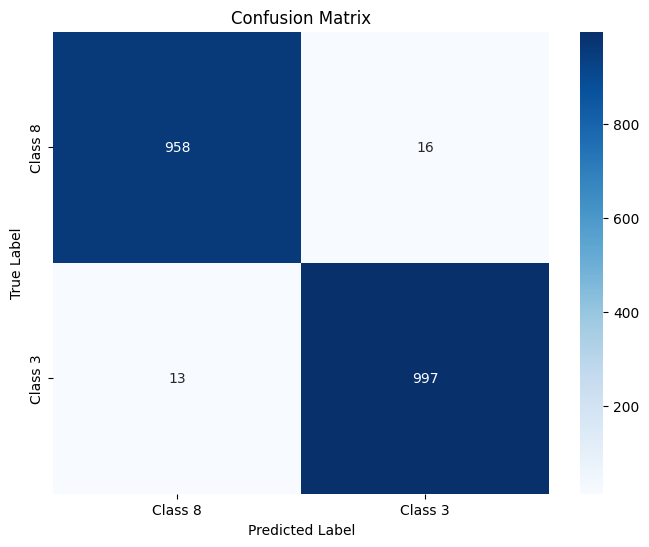

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 8', 'Class 3'],
            yticklabels=['Class 8', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Saving the model

In [29]:
joblib.dump(final_model, 'best_svm_model.joblib')
print("Best model saved to best_svm_model.joblib")

Best model saved to best_svm_model.joblib
